# HW 3

In [178]:
import psycopg2
import getpass
import numpy as np
import datetime
import time
import pandas as pd
import dateutil.relativedelta as dr
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


In [3]:
def coupon_count(coup_str):
        full_matrix = pd.DataFrame() # local var
        end_date = coup_str.BUYBACKDATE.values[0] if coup_str.BUYBACKDATE.values[0] is not None else coup_str.EndMtyDate.values[0]
        a = int(coup_str.CouponPerYear.values[0])
        b = float(coup_str.NumCoupons.values[0])
        types = True
        if coup_str.CPN is not None or coup_str.CPN != 0:
            if coup_str.AmortisedMty.astype(str).values[0] == 'False':
                types = False
                amount = coup_str.CPN.values[0]
                for j in np.linspace((b - 1) / a, 0, b):
                    date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25 * j))
                    if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                        date = end_date
                        amount = coup_str.BUYBACKPRICE.values[0]
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                        date = end_date
                        amount += coup_str.FaceValue.values[0]
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    amount = coup_str.CPN.values[0]
            else:
                percent = float(coup_str.CPN.values[0]) / float(coup_str.FaceValue.values[0])
                index = (b - 1)
                face = coup_str.FaceValue.values[0]
                while index >= 0:
                    amount = percent * face
                    date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25*index/a))
                    if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                        date = end_date
                        amount = coup_str.BUYBACKPRICE.values[0]
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                        date = end_date
                        amount = face
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    index -= 1
                    face = face * (1 - percent)
        my_index = pd.MultiIndex.from_tuples([(coup_str.ISIN.values[0], 'Amortised' if types else 'Not Amortised'
                                               , coup_str.IssuerName.values[0] )], names=['ISIN', 'Amortisation', 'Issuer'])
        full_matrix = pd.DataFrame(full_matrix.values, index = my_index, columns = full_matrix.columns)
        return full_matrix


def crazy(issuer_name, date, db_login, from_date_matrix):

    conn = psycopg2.connect(user = db_login['user'],
                            database = db_login['database'], 
                            host = db_login['host'], 
                            port = db_login['port'], 
                            password = getpass.getpass('Insert password: '))

    query = """SELECT *
            FROM (SELECT MAX("CPN") AS "CPN", "ISIN", max("BUYBACKDATE") AS "BUYBACKDATE",
                  max("BUYBACKPRICE") AS "BUYBACKPRICE"
                  FROM public.quotes_task  
                  GROUP BY "ISIN") AS a
            INNER JOIN(SELECT "ISINCode", "FaceValue", "HaveOffer", "AmortisedMty", 
                       "CouponPerYear", "NumCoupons", "EndMtyDate", "CouponType", "IssuerName"
                       FROM public.bond_description_task 
                       WHERE "Status"!='Погашен') AS b
            ON a."ISIN" = b."ISINCode";"""

    # read query in python

    data = pd.read_sql_query(query, conn) 

    # Extract more specified data 
    data.drop(['ISINCode'], axis=1)
    data.BUYBACKPRICE = data.BUYBACKPRICE.fillna(0)
    data = data[~data.CPN.isna()].reset_index(drop = True)
    data = data[data.CPN != 0]
    data = data[data.CouponPerYear > 0]

    # if you had timestamp format in any of extracted fields so change format to date
    # in my case it was only buybackdate
    
    full_matrix = pd.DataFrame()

    # fill in full_matrix

    for i in data.iterrows():
        full_matrix = pd.concat([full_matrix, coupon_count(pd.DataFrame(i[1]).T)], sort = True)
        full_matrix = full_matrix.fillna(0)
    
    results = {'ISSUER': issuer_name, 'DATE': date, 'MATRIX_OF_PAYMENTS': from_date_matrix(issuer_name, date, full_matrix)}
    return results

In [4]:
def from_date_matrix(issuer_name, date, full_matrix):
        spec_payments = pd.DataFrame()
        for i in range(0, len(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns)):
            date_size = int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, \
            how = 'all').fillna(0).columns[i].split('-')[0]) * 365 + int(full_matrix.xs(str(issuer_name), \
            level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[1]) * 365/12 + \
            int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[2])
            if int(date.split('-')[0]) * 365 + int(date.split('-')[1]) * 365/12 + int(date.split('-')[2]) < date_size:
                data = full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).iloc[:, i:i+1]
                spec_payments = pd.concat([spec_payments, data], axis = 1)
        return spec_payments

In [26]:
user = input('User of database: ' )
database = input('Name of database: ' )
host = input('Host: ' )
port = input('Port: ' )
emitent = input('Issuer name: ')
start_date_for_u  = input('Date in format YYYY-MM-DD: ')

login = {'user': user, 'database': database, 'host': host, 'port': port}
x = crazy(emitent, start_date_for_u, login, from_date_matrix)
print(x['ISSUER'], x['DATE'])
x['MATRIX_OF_PAYMENTS'].loc[:, (x['MATRIX_OF_PAYMENTS'] != 0).any(axis = 0)]

User of database: postgres
Name of database: postgres
Host: localhost
Port: 5432
Issuer name: Татфондбанк АИКБ
Date in format YYYY-MM-DD: 2015-09-21
Insert password: ········


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


Татфондбанк АИКБ 2015-09-21


,,2015-10-07,2015-12-12,2015-12-23,2016-02-05,2016-03-14,2016-03-21,2016-04-01,2016-04-06,2016-09-13,2016-10-06
ISIN,Amortisation,,,,,,,,,,
RU000A0JTLE4,Not Amortised,0.00,0.00,0.0,1084.77,0.00,0.0000,0.0,0.00,0.00,0.00
RU000A0JU5G0,Not Amortised,0.00,0.00,0.0,0.00,69.62,0.0000,0.0,0.00,1069.62,0.00
RU000A0JU732,Not Amortised,84.77,0.00,0.0,0.00,0.00,0.0000,0.0,84.77,0.00,1084.77
RU000A0JV3B5,Not Amortised,0.00,69.81,100.0,0.00,0.00,0.0000,0.0,0.00,0.00,0.00
RU000A0JVBJ0,Not Amortised,0.00,0.00,0.0,0.00,0.00,74.7945,100.0,0.00,0.00,0.00


In [7]:
buf = x['MATRIX_OF_PAYMENTS']
buf = x['MATRIX_OF_PAYMENTS'].T[buf.sum().values > 0].T

In [8]:
bbuf = buf.groupby('Amortisation').sum()

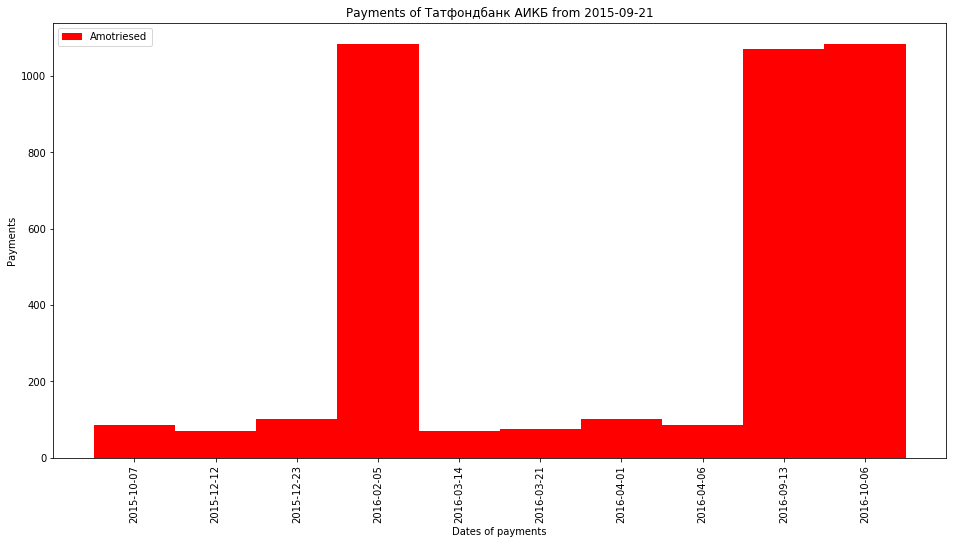

In [30]:
dates_graph = bbuf.columns

if int(bbuf.shape[0])==1:
    amort = bbuf.iloc[0]
    plt.subplots(figsize=(16,8))
    p1 = plt.bar(dates_graph, amort, width = 1, color="red")
    plt.xlabel('Dates of payments')
    plt.xticks(rotation=90)
    plt.ylabel('Payments')
    plt.title('Payments of '+ str(emitent) + ' from ' + str(start_date_for_u))
    plt.legend(['Amotriesed'])
    payments_graph = plt.show(p1)
    payments_graph
    
    
    
if int(bbuf.shape[0])==2:
    plt.subplots(figsize=(16,8))
    p1 = plt.bar(dates_graph, amort, width = 1, color="red")
    p2 = plt.bar(dates_graph, not_amort, width = 1, bottom=amort, color="blue")

    plt.xlabel('Dates of payments')
    plt.xticks(rotation=90)
    plt.ylabel('Payments')
    plt.title('Payments of '+ str(emitent) + ' from ' + str(start_date_for_u))
    plt.legend((p1[0], p2[0]), ('Amotriesed', 'Non amortiezed'))

    payments_graph = plt.show(p1, p2)
    payments_graph

In [31]:
def year_delta(cur, base):
    return (datetime.strptime(cur, '%Y-%m-%d') - datetime.strptime(base, '%Y-%m-%d')).days / 365

def duration(times, coup, price, ytm):
    times = np.array(times)
    coup = np.array(coup)
    return np.exp(- ytm * times) * coup * times / price

In [32]:
date_x = str(start_date_for_u)
issuer_x = str(emitent)

conn=psycopg2.connect(user='postgres', 
                      database='postgres', 
                      host='localhost',
                      port=5432,
                      password='21qwsa34redf')

query_x = """SELECT issu."ISINCode" as "ISIN"
                , ytm."YIELD_BID"
                , ytm."BID"
            FROM public.bond_description_task as issu
            join quotes_task as ytm 
                on issu."ISINCode" = ytm."ISIN"
                and ytm."TIME" = '{date_x}'
                and issu."IssuerName" = '{issuer_x}'
            WHERE issu."Status"!='Погашен'
        ;""".format(date_x = date_x, issuer_x = issuer_x)

df2 = pd.read_sql_query(query_x, conn) 
df2 = df2.set_index('ISIN')

buf2 = buf.reset_index('Amortisation', drop=True)

res = pd.concat([buf2, df2], axis = 1, sort = True)

yield_nan_num = len(res[res.YIELD_BID.isna()])

res = res[~res.YIELD_BID.isna()] # keep those which has yield

if len(res) == 0: # Do we have something to plot
    print('Nothing to plot :`('\
         'all bonds have no YTM_data'\
         str(yield_nan_num)+' '+'are non_yield')
    #return ({'non_yield': yield_nan_num}) # something need to be return here

ISINs = []
Durations = []

for j, i in res.iterrows():
    a,b = j,i
    y_times = list(map(lambda x: year_delta(x, date_x),b.index[:-2]))
    ytm_value = b[-2] / 100
    price_value = b[-1]
    Durations.append(duration(y_times, b[:-2], price_value, ytm_value).sum())
    ISINs.append(a)
    
ISIN_DURATION = pd.DataFrame(list(zip(ISINs, Durations)), columns = ['ISIN', 'time']).sort_values('time')


In [33]:
 ISIN_DURATION['ISIN'].to_list()

['RU000A0JV3B5',
 'RU000A0JVBJ0',
 'RU000A0JTLE4',
 'RU000A0JU5G0',
 'RU000A0JU732']

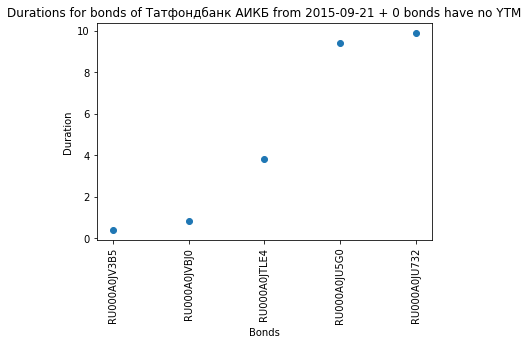

In [124]:
plt.scatter(ISIN_DURATION['ISIN'].to_list(), ISIN_DURATION['time'].to_list()) 
plt.xticks(rotation=90)
plt.xlabel('Bonds')
plt.ylabel('Duration')
plt.xticks(rotation = 90)
plt.title('Durations for bonds of '+ str(emitent) + ' from ' + str(start_date_for_u) + ' + ' + str(yield_nan_num) + ' bonds have no YTM')
dur_graf=plt.show()
dur_graf

# HW 4

In [ ]:
# Примеры и форму отчета можно посмотреть здесь

# https://drive.google.com/drive/folders/1SsCQSTJmpjZSBHmGXfz6AGhJFhR1R43L?usp=sharing

In [159]:
path_by_default = 'C:\\Users\\User\\Desktop\\HSE\\IT\\Home-work-BONDS'
name_by_default = 'Matrix of payments of ' + str(x['ISSUER']) + ' from ' + str(x['DATE']) + \
                             ' updated ' + str(str(datetime.today())[:-16]) + '.csv'
filename = path_by_default + '\\' + name_by_default
buf.to_csv(filename, index = True)
#Чтобы привести таблицу в читаемый вид, используйте следующий прием: выделить первый столбец-нажать "Данные"-"Текст по столбцам"
#- разделитель "Запятая"

In [160]:
# Для самостоятельной калибровки настроек
name_by_user = input('Insert name of table: ')
path_by_user = input('Insert path for table using backslash: ')
buf.to_csv((path_by_user + '\\' + name_by_user + '.csv'), index = True)
#Чтобы привести таблицу в читаемый вид, используйте следующий прием: выделить первый столбец-нажать "Данные"-"Текст по столбцам"
#- разделитель "Запятая"

Insert name of table: 1
Insert path for table using backslash: 1


FileNotFoundError: [Errno 2] No such file or directory: '1\\1.csv'

In [161]:
def export_table(type):
    type = int(input('1=default,  0=user settings'))
    if type == 1:
        from datetime import datetime
        path_by_default = 'C:\\Users\\User\\Desktop\\HSE\\IT\\Home-work-BONDS'
        name_by_default = 'Matrix of payments of ' + str(x['ISSUER']) + ' from ' + str(x['DATE']) + \
                             ' updated ' + str(str(datetime.today())[:-16]) + '.csv'
        filename = path_by_default + '\\' + name_by_default
        buf.to_csv(filename, index = True)
        next_instruction = 'Чтобы привести таблицу в читаемый вид, используйте следующий прием: выделить первый столбец-нажать "Данные"\
        -"Текст по столбцам"- разделитель "Запятая"'
        return path_by_default, name_by_default, next_instruction
    elif type == 0:
        name_by_user = input('Insert name: ')
        path_by_user = input('Insert path: ')
        buf.to_csv((path_by_user + '\\' + name_by_user + '.csv'), index = True)
        next_instruction = 'Чтобы привести таблицу в читаемый вид, используйте следующий прием: выделить первый столбец-нажать "Данные"\
        -"Текст по столбцам"- разделитель "Запятая"'
        return path_by_user, name_by_user, next_instruction
    else:
        print('Never give up')
        
        
        
        
        

In [162]:
export_table(type)
# type=1

1=default,  0=user settings1


('C:\\Users\\User\\Desktop\\HSE\\IT\\Home-work-BONDS',
 'Matrix of payments of Татфондбанк АИКБ from 2015-09-21 updated 2019-12-21.csv',
 'Чтобы привести таблицу в читаемый вид, используйте следующий прием: выделить первый столбец-нажать "Данные"        -"Текст по столбцам"- разделитель "Запятая"')

In [202]:
def export_picture(type):
    type = int(input('1=default,  0=user settings'))   
    plt.scatter(ISIN_DURATION['ISIN'].to_list(), ISIN_DURATION['time'].to_list()) 
    plt.xticks(rotation=90)
    plt.xlabel('Bonds')
    plt.ylabel('Duration')
    plt.xticks(rotation = 90)
    plt.title('Durations for bonds of '+ str(emitent) + ' from ' + str(start_date_for_u) + ' + '
              + str(yield_nan_num) + ' bonds have no YTM')
        
    if type == 1:
        from datetime import datetime
        path_by_default = 'C:\\Users\\User\\Desktop\\HSE\\IT\\Home-work-BONDS'
        name_by_default = 'Duration for ' + str(x['ISSUER']) + ' from ' + str(x['DATE']) + \
                                     ' + ' + str(yield_nan_num)+ " bonds have no YTM" + '.png'
        
        filename = path_by_default + '\\' + name_by_default
        plt.savefig(filename)
        return path_by_default, name_by_default
    if type == 0:
        name_by_user = input('Insert name: ')
        path_by_user = input('Insert path: ')
        plt.savefig(path_by_user + '\\' + name_by_user + '.jpg')
        return path_by_user, name_by_user
    else:
        print('Never give up')
        



        



1=default,  0=user settings1


('C:\\Users\\User\\Desktop\\HSE\\IT\\Home-work-BONDS',
 'Duration for Татфондбанк АИКБ from 2015-09-21 + 0 bonds have no YTM.png')

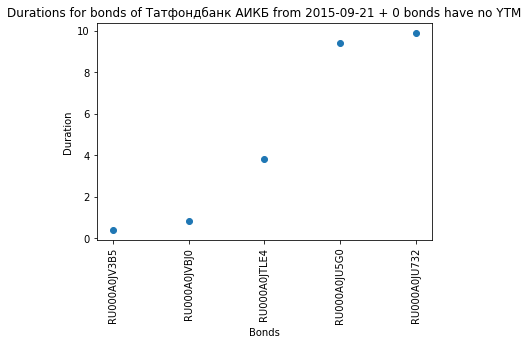

In [203]:
export_picture(type)
#type=1

In [206]:
# Если есть проблемы с установкой gtk (она не помогает решить проблему cairo)
# скопируйте все содержимое GTK3-Runtime Win64\bin в Anaconda3\Library\bin

1=default,  0=user settings1
1=default,  0=user settings1
1=default,  0=user settings1


OSError: [Errno 22] Invalid argument: 'C:\\Users\\User\\Desktop\\HSE\\IT\\Home-work-BONDS\\report Татфондбанк АИКБ from 2015-09-21.pdf'

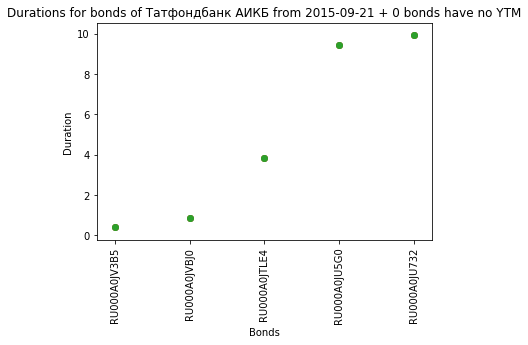

In [205]:

from __future__ import print_function
from jinja2 import Environment, FileSystemLoader
from weasyprint import HTML, Document
import os

env = Environment(loader = FileSystemLoader('.'))
template = env.get_template("myreport.html") 
template_vars = {"title": "Отчет составлен Потаповым Артёмом Игоревичем",
                "INTRO": "Данный отчет содержит график платежей портфеля из облигаций эмитента" + str(x['ISSUER']) + \
                 " на дату " + str(x['DATE']) 
                 + " профиль чувствительностей ", 
                 "TABLE_DESC": "В таблице представлен график платежей по всем непогашенным облигациям "+ str(x['ISSUER'])\
                 + " с даты " + str(x['DATE']) + " по дату последней выплаты. В столбцах размер плателей на конкретную дату, \
                 по строкам - размер платежей по 1 бумаге", 
                 "TABLE": buf.T.to_html(), 
                 "IMAGE_DESC": "На графике изображены дюрации всех непогашенных бумаг "+ str(x['ISSUER']) + " на "
                 + str(x['DATE']), 
                 "IMAGE": os.path.realpath(export_picture(type)[0] + '\\' + export_picture(type)[1])
                }


html_out = template.render(template_vars, presentational_hints=True)
HTML(string = html_out).write_pdf(export_picture(type)[0] + "\\" + "report " + str(x['ISSUER']) + " from " \
                                  + str(x['DATE']) + ".pdf", presentational_hints = True)